# Welcome to this month's Central London Data Science Meetup! 

Let's be honest, we have all seen a comment on Stack Overflow that has seemed rude. If you're not convinced just search "stack overflow rude".

But why are they? Stack overflow is an amazingly useful tool and the fact that random members of the internet will take large amounts of time to answer 1000s of questions with in depth answers is still amazing. However, as always with the internet, a small minority of people can ruin it for everyone else!

But why is this the case? Are there any patterns as to why? For example, are people more rude at certain times of the day? Could these patterns be then used to help advise people about how to post better questions and answers? Does this have any impact on how well received the answer is? Are nicer answers more often accepted?

These may seem like ambitious aims but in this meetup we will look at a few tools that can help you begin to tackle this question and bring together a range of useful generalist skills that should help any data scientist. 


# 1. Getting data from BigQuery

First we need to get our data for our investigation. [BigQuery](https://cloud.google.com/bigquery/) by Google is a data warehouse that can be very useful for larger projects. They also maintain a number of public database collections that make for excellent data sets to test your data science skills on. 

In today's problem we are going to be looking at the Stack Overflow database. BigQuery has very usefully maintained a database of questions and answers and other metadata from Stack Overflow. A description of this database can be found [here](https://cloud.google.com/blog/products/gcp/google-bigquery-public-datasets-now-include-stack-overflow-q-a) and is very worth a read through as it describes the data fully. 

---

There are a few ways that we can do about downloading data from BigQuery. 

#### 1. Go to BigQuery directly and create our SQL request and download the dataset manually

If you head to [BigQuery](https://cloud.google.com/bigquery/) and register for a Google Cloud account you can query the databases directly from their Google Cloud Platform. This approach can be very useful if you don't know what data it is you want and you want to have an interactive dashboard from which you can view the structure of each database hosted within BigQuery. This is where I went first to work out which tables within the Stack Overflow BigQuery database we needed for this meetup. 

For example, below you can see an overview of what this interface looks like:

![](https://raw.githubusercontent.com/central-ldn-data-sci/stack_overflow/master/images/Screenshot%20from%202019-05-26%2016-20-44.png)

#### 2. Query BigQuery directly using python

The second option is to use the `BigQuery` namespace provided by the `google.cloud` package. This is what we will demonstrate in this meetup. 

For some guidance on how to fill in the next section of code have a look at [this link](https://www.kaggle.com/product-feedback/48573).

---



In [1]:
from google.cloud import bigquery
import pandas as pd

def stack_user_answers(x):
    '''Returns a data frame of Stack Overflow answers for requested user IDs
    Args:
    * x - (list) List of user id integers to be queried
     
    Return
    * (pd.DataFrame) - DataFrame of Stack Overflow answers
    '''

    # create our bigquery client
    client = bigquery.Client()

    # create our SQL string query with our user ids
    query = """
    SELECT
      id, owner_display_name, body, creation_date, owner_user_id, score, tags
    FROM
      `bigquery-public-data.stackoverflow.posts_answers`
    WHERE 
      owner_user_id IN (""" + None + """)
    """

    # make our query using the client
    query_job = client.query(None)

    # iterate through the result
    iterator = query_job.result()
    rows = list(iterator)

    # Transform the rows into a nice pandas dataframe
    data = pd.DataFrame(data=[list(x.values()) for x in rows], columns=list(rows[0].keys()))
    
    return(data)

# 2. Finding users from Stack Overflow

Now we have a function to return information about answers from Stack Overflow for given user IDs. But which user's should we get data for?

---

You can have a look for the user id's of anyone you would like to, but for the purposes of this meetup let's take the top 10 user who answer questions tagged with either the `r` or `python` tag. These individuals are likely to have the most amount of data on (i.e. answers) over the longest period of time so these seem like a good starting point. 

To collect these individuals we will need to write a little function to scrape these user's IDs from the Stack Overflow website. 

We have looked at scraping information from web pages in a previous meetup - [Web Scraping and NLP](https://github.com/central-ldn-data-sci/web-scraping-and-nlp-CLDSPN). In that meetup we were selecting elements from a page of html based on their **tags** and **class** elements using the package `BeautifulSoup`. For a refresher of that approach have a look back at that meetup. 

Today we will be scraping information that cannot be easily scraped using attributes because the same attributes are used for other information on the page. For example if we head to https://stackoverflow.com/tags/python/topusers:

![](https://raw.githubusercontent.com/central-ldn-data-sci/stack_overflow/master/images/Screenshot%20from%202019-05-27%2016-55-29.png)

For example, we are trying to get the user id for the users on the right, i.e. the All Time top answerers. If we were to inspect the page for their attributes we could try and scrape the information this way:

In [2]:
import requests
from bs4 import BeautifulSoup
url = 'https://stackoverflow.com/tags/python/topusers'
article_response = requests.get(url)
souped_page = BeautifulSoup(article_response.text, 'html.parser')
info = souped_page.find_all('div',{'user-details'})
info[0]


<div class="user-details">
<a href="/users/2901002/jezrael">jezrael</a>
<div class="-flair">
<span class="reputation-score" dir="ltr" title="reputation score 374,730">375k</span><span title="27 gold badges"><span class="badge1"></span><span class="badgecount">27</span></span><span title="349 silver badges"><span class="badge2"></span><span class="badgecount">349</span></span><span title="428 bronze badges"><span class="badge3"></span><span class="badgecount">428</span></span>
</div>
</div>

As we can see this will get us all the user's. It may be easier in this case to scrape using CSS selectors. 

---

To scrape using CSS selectors there is a fantastic tool called [SelectorGadget](https://selectorgadget.com/) that helps us create a CSS selector that can get us specific information from web page. It can easily be installed as a Chrome extension as well or added as a Bookmark Bar javascript function. 

Before going forward I recommend having a look at the [SelectorGadget](https://selectorgadget.com/) web page and seeing how to use it to create a selector that will grab all the Top Users from the python webpage. 

---

Once you have done that hopefully you will be able to identify the following CSS selector:



In [3]:
css_selector = ".grid--cell+ .grid--cell .user-details a"

Let's now construct a function to grab the user id's with this CSS. 

In [4]:
import requests
import lxml.html
import numpy as np
from lxml import html
!pip install cssselect
from lxml.cssselect import CSSSelector
import re

def get_top_x_answerers(url, x, quiet = False):
    '''Returns a list of the user ids 
     Args:
     * url - (str) URL that we are querying for user details
     * x - (int) The number of users we want to return
     * quiet -(bool) Do we want to print the info of the top x users. Default = False
     
     Return
     * (list) - List of integers for the user
     '''
    
    # Get out page of html
    article_response = requests.get(None)
    
    # Get the html tree from the page
    tree = html.fromstring(article_response.content)
    
    # Pass in the selected CSS
    answerers = tree.cssselect(None)
    
    # Build a dictionary of the user names and ids
    top_users = {}
    for i in range(x):
        
        # grab the string from the answer we are looping over
        s = lxml.html.tostring(None)
        if not quiet:
            print(answerers[i].get("href"))
            
        # use a regex string to grab the name of the user
        user = re.findall("/[\D]+/[\d]+/([\D|\d]+)",answerers[i].get("href"))[0]
        
        # another regex for their id
        user_id = (re.findall("[\d]+",answerers[i].get("href"))[0])
        
        # fill in our dictionary with the key being their name and the value as the user_id
        top_users[None] = None
        
    # let's just return the user ids, i.e. the values in our dict that we built above
    return(None)

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# 3. Build our data set

Now that we have functions to start creating our dataset, let's use them! After we have finished we should end up with a dataset that looks like the following:

![](https://raw.githubusercontent.com/central-ldn-data-sci/stack_overflow/master/images/Screenshot%20from%202019-05-27%2017-43-06.png)

Firstly, let's get the IDs of the top 10 users for both R and Python questions:

> **Hint:** You have to fill in the following cell and uncomment some lines

In [5]:
# Let's grab the top 10 python users
python_url = 'https://stackoverflow.com/tags/python/topusers'
# python = get_top_x_answerers(url = None, x = 10, quiet = False)

# And fill in the url as needed for the r users
r_url = None
# r = get_top_x_answerers(url = None, x = 10, quiet = True)

Now using those ids, let's create a dataframe of the answers from BigQuery:

(N.B. This code can error at times due to 403 Server Errors - so I have wrapped it in try statements that will read the data in if they fail from the same data saved to file

In [6]:
# get the answers from our top users
try:
    r_df = stack_user_answers(r)
except:
    r_df = pd.read_csv("../input/stack-answers-r-python/r_10.csv")
    
try:    
    python_df = stack_user_answers(python)
except:
    python_df = pd.read_csv("../input/stack-answers-r-python/python_10.csv")

Lastly, let's tag these answers as either `r` or `python` before joining the two data frames together.

In [7]:
# mark the answers as either r or python and bind the data frames together
r_df['language'] = "r"
python_df['language'] = None

data = r_df.append(None)
data.head(5)

,id,owner_display_name,body,creation_date,owner_user_id,score,tags,language
0,42661225,NaN,<p>Here are a couple of <code>base R</code> su...,2017-03-08 01:10:07.783 UTC,3732271,-1,NaN,r
1,10353203,NaN,<p>This has been asked many times before. The ...,2012-04-27 15:12:17.877 UTC,602276,32,NaN,r
2,44504704,NaN,"<p>In <code>R</code>, we can do this with <cod...",2017-06-12 16:48:38.917 UTC,3732271,-1,NaN,r
3,10291814,NaN,<p>Since <code>.rda</code> requires <code>load...,2012-04-24 04:38:46.37 UTC,1270695,39,NaN,r
4,5823670,NaN,<p>If you want to examine elements inside a da...,2011-04-28 19:03:12.097 UTC,1855677,40,NaN,r


This is a great start for our dataset, but we could add more information. For example, it would be excellent to know if these answers were the accpeted answer or not.

Unfortunately this information (I don't think) is stored in the BigQuery database. So what do we do:

#### 1. Assume that Stack Overflow does not have an API and scrape this information

It's never a good idea to scrape a website for information before checking whether there is an API or not. However, let's pretend we have done this and think about how we can scrape the required information from the Stack Overflow website. 

In [8]:
def accepted_answer(id):
    '''Returns a boolean value (0 or 1) for if the answer ID was accepted
    Args:
    * id - (Numeric) Answer ID
     
    Return
    * 1 or 0
    '''
    
    id = str(id)
    url = "https://stackoverflow.com/a/" + id
    article_response = requests.get(url)
    tree = html.fromstring(article_response.content)
    div = tree.get_element_by_id("answer-" + id)
    
    if div.get("itemprop") == 'acceptedAnswer':
        return 1
    else:
        return 0
        

However, you will quickly become throttled by Stack Overflow. 

![](https://raw.githubusercontent.com/central-ldn-data-sci/stack_overflow/master/images/Screenshot%20from%202019-05-27%2013-37-03.png)

#### 2. Look for an API

There is another solution, though, which is to use their [API](https://api.stackexchange.com/). If we look at their API we can see that if we query the **answers** endpoint (http://api.stackexchange.com/answers/) we can grab information about whether the answer was accepted. We also can see that we can only make API requests (without registering) at 100 at a time, so let's make a function that returns a list of whether an answer (as supplied using its id) is accepted. 

In [9]:
import json

def accepted_api(ids):
    '''Returns a list of Booleans for whether the answer was accepted
    Args:
    * ids - (List) List of numeric answer ids
     
    Return
    * List of Booleans
    '''
    
    base_url = "http://api.stackexchange.com/answers/"
    end_url = "?order=desc&sort=activity&site=stackoverflow"
    ids = ";".join(ids.map(str))
    url_req = '{}{}{}'.format(base_url,ids,end_url)
    resp = requests.get(url_req).json()
    return([c['is_accepted'] for c in resp['items']])


Now let's apply this function in chunks of 100 at a time to respect the API return sizes and then append the result to our data frame.

(N.B. Again due to throttling I have saved the output as a csv to be read in when we inevitably have throttling issues)

> **Hint:** Below have a go at filling in the code that is within the `try:` statement. It may still error if it's correct (due to network issues), in which case the `except:` statment will load the correct data.

In [10]:
import itertools

def chunks(seq, size):
    '''Returns a generator object with each element representing the next size x elements from seq
    Args:
    * seq - (List) List of elements to break up into chunks of size = size
    * size - (Numeric) Numeric for length of each chunk
     
    Return
    * Generator object
    '''
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

try:
    accepteds = [accepted_api(None) for group in chunks(data[None], 100)]
    data['accepted'] = pd.Series(list(itertools.chain.from_iterable(accepteds)))
except:
    accepteds = pd.read_csv("../input/stack-answers-r-python/accepted.csv")
    data = pd.merge(data, accepteds, on='id')
    
data.head(5)

,id,owner_display_name,body,creation_date,owner_user_id,score,tags,language,accepted
0,42661225,NaN,<p>Here are a couple of <code>base R</code> su...,2017-03-08 01:10:07.783 UTC,3732271,-1,NaN,r,False
1,10353203,NaN,<p>This has been asked many times before. The ...,2012-04-27 15:12:17.877 UTC,602276,32,NaN,r,True
2,44504704,NaN,"<p>In <code>R</code>, we can do this with <cod...",2017-06-12 16:48:38.917 UTC,3732271,-1,NaN,r,True
3,10291814,NaN,<p>Since <code>.rda</code> requires <code>load...,2012-04-24 04:38:46.37 UTC,1270695,39,NaN,r,True
4,5823670,NaN,<p>If you want to examine elements inside a da...,2011-04-28 19:03:12.097 UTC,1855677,40,NaN,r,False


# 4. Tidy Our Dataset

We are very close to finishing creating our dataset. At the moment we have lots of great information and we will soon be wanting to have a go at some sentiment analysis on the answers given. However, if we have a look at the answers given we can see there is a little of code included in user's answers:

In [11]:
data['body'][0]

'<p>Here are a couple of <code>base R</code> suggestions.  Loop through the columns of datasets, convert it to a logical vector, and collapse the logical vectors by comparing each corresponding element with <code>Reduce</code>, negate the output and subset the dataset</p>\n\n<pre><code>df[!Reduce(`&amp;`, lapply(df, is.na)),]\n</code></pre>\n\n<p>Or converting the logical matrix (<code>!is.na(df)</code>) to a logical <code>vector</code> to subset the dataset</p>\n\n<pre><code>df[rowSums(!is.na(df))&gt;0,]\n</code></pre>\n\n<h3>data</h3>\n\n<pre><code>df &lt;- data.frame(a = c(2, 4, 6, NA, 3, NA),\n         b = c(5, 4, 8, NA, 6, 7))\n</code></pre>'

The actual written code and the html tags (`<pre>`, `<p>` etc) are unlikely to change the results of the sentiment analysis very much (unless they have given their variable names etc very aggressive or friendly names). However, they will slow down how quickly we can calculate the sentiment etc of each answer. So it would be a good idea to tidy these responses up to just store the actual English response given. There are a couple of tools that we can use for this. We can either use `BeautifulSoup` to parse the response and then grab the text:

In [12]:
bs = BeautifulSoup(data['body'][0], 'html.parser')
print(bs.text)

Here are a couple of base R suggestions.  Loop through the columns of datasets, convert it to a logical vector, and collapse the logical vectors by comparing each corresponding element with Reduce, negate the output and subset the dataset
df[!Reduce(`&`, lapply(df, is.na)),]

Or converting the logical matrix (!is.na(df)) to a logical vector to subset the dataset
df[rowSums(!is.na(df))>0,]

data
df <- data.frame(a = c(2, 4, 6, NA, 3, NA),
         b = c(5, 4, 8, NA, 6, 7))



Or we could use provided html parsers provided within `html.parser` and wrap this with some regex to get just the text. The following goes one step further than `BeautifulSoup` and will actually remove the coded contents as well as the html tags:

In [13]:
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def just_text(x):
    return(re.sub("\n<pre><code>.*?</code></pre>|</p>|<p>|<code>.*?</code>|\n"," ", x,flags=re.DOTALL))
    
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

print(data['body'][0:1].apply(just_text).apply(strip_tags)[0])

 Here are a couple of   suggestions.  Loop through the columns of datasets, convert it to a logical vector, and collapse the logical vectors by comparing each corresponding element with  , negate the output and subset the dataset      Or converting the logical matrix ( ) to a logical   to subset the dataset     data  


We can see that the BeautifulSoup text clean is a bit neater so let's turn that into a function to apply to our `body` data. 

> **Hint:** Look above for how we used BeautifulSoup to clean the text. Once you have filled in the function uncomment the second last line of code and comment the last to use the cleaned text going forwards.

In [14]:
def clean_soup(x):
    '''Clean a block of text using BeautifulSoup
    Args:
    * x - (str) Text block to be cleaned
     
    Return
    * Cleaned str
    '''
    bs = BeautifulSoup(None, 'html.parser')
    return(None)

# data['text'] = data['body'].apply(clean_soup)
data['text'] = data['body']

Phew! We have now got a really great dataset to start analyzing. If it seemed like this took ages then don't worry as the actual analysis is often actually quicker! If we remember Blair's meetup last time he came up with this gem that is very true:

> '90% of a data scientist time is spent sourcing and then cleaning the data'

# 5. Sentiment Analysis

Now that we have our dataset we can use the cleaned text of each answer given, and calculate what the sentiment of the answer given is. 

For a reminder of sentiment analysis you can look back at one of our [earlier meetups](https://github.com/central-ldn-data-sci/web-scraping-and-nlp-CLDSPN/blob/master/%5BCOMPLETED%5D%20Web%20Scraping%20and%20NLP.ipynb) on NLP looking at assessing the subjectivity and polarity of articles on Tech Crunch. In that meetup we used `TextBlob` for our sentiment analysis. We will be doing the same here but also bringing in an alternative NLP tool from `nltk` that is specifically tailored for sentiments expressed in social media - VADER. For more info see their [github](https://github.com/cjhutto/vaderSentiment). 

For example, to estimate the sentiment for the following sentence: "This is a terrific meetup :)"

---

In [15]:
from textblob import TextBlob
import nltk.sentiment.vader
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

demo = "This is a terrific meetup :)"
blob = TextBlob(demo)
print(blob.sentiment)

scores = analyzer.polarity_scores(demo)
print(scores)

Sentiment(polarity=0.25, subjectivity=1.0)
{'neg': 0.0, 'neu': 0.33, 'pos': 0.67, 'compound': 0.7269}


/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


TextBlob returns a value pair representing the sentiment scores for the text.

Here is a section of the TextBlob documentation that explains what the values in the value pair mean:

From https://textblob.readthedocs.io/en/dev/api_reference.html#textblob.blob.TextBlob.sentiment

> `TextBlob.sentiment`

> Return a tuple(value pair) of form (polarity, subjectivity ) where polarity is a float(number) within the range [-1.0, 1.0] and subjectivity is a float(number) within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective.

So we can see that it thinks the sentence is slightly positive but completely subjective.

---

However, if we have a look at the polarity when using the VADER sentiment analysis, we can see that it believes the sentence is more strongly positive (likely because of the smiley face!). The [documentation](https://github.com/cjhutto/vaderSentiment#about-the-scoring) can explain further what the values returned mean:

* The pos, neu, and neg scores are ratios for proportions of text that fall in each category (so these should all add up to be 1... or close to it with float operation). These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

* The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

---

So let's return the polarity, subjectivity and compound score and add it to our dataset.

> **Hint:** You need to complete the function below and then uncomment the text to finish creating our dataset


In [16]:
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def nlp_pol_subj(text):
    '''Carries out sentiment analysis on text
    Args:
    * x - (str) Text block to be analysed
     
    Return
    * Tuple of length 3 containing the polarity, subjectivity and compound score
    '''
    blob = TextBlob(None)
    scores = analyzer.polarity_scores(None)
    return None, None, None

# nlp_df = data['text'].map(None).apply(pd.Series, index = ["Polarity", "Subjectivity","Compound"])
# data = pd.concat([data, nlp_df], axis = 1)

---


Making our dataset is taking a long tie and has had to run a lot of intensive calculations so it would be a good idea to save this data so that we can quickly load it again in the future.

In [17]:
# data.to_pickle("data.pkl")


## N.B. If you are less interested in how this data was generated (i.e the above) then you can start here by loading in the dataset

In [18]:
import pandas as pd
data = pd.read_pickle("../input/stack-overflow-output/data.pkl")
data.creation_date = [pd.to_datetime(p) for p in data.creation_date.values]

However, we now have our wonderful dataset ready to go. Have a break and some pizza as that was a lot of work. But here is our dataset with sentiment analyses added in:

In [19]:
data.head(5)

,id,owner_display_name,body,creation_date,owner_user_id,score,tags,language,accepted,text,Polarity,Subjectivity,Compound
0,6254606,,<p><code>expand.grid</code> is your friend:</p...,2011-06-06 15:49:55.693,602276,23,,r,True,expand.grid is your friend:\nexpand.grid(prefi...,0.400000,0.700,0.7184
1,6262262,,<p>The built-in function <code>system.time()</...,2011-06-07 08:01:58.220,602276,162,,r,True,The built-in function system.time() will do it...,0.000000,0.000,0.3612
2,12325377,,<p>You put the <code>.Rnw</code> sources in <c...,2012-09-07 21:04:16.527,429846,20,,r,True,You put the .Rnw sources in vignettes/ as you ...,0.000000,0.425,0.0772
3,5522870,,<p>You have the name of the package wrong - it...,2011-04-02 11:29:21.763,429846,21,,r,False,You have the name of the package wrong - it is...,0.060417,0.500,0.3182
4,10555270,,<p>Here are two options:</p>\n\n<pre><code>lib...,2012-05-11 16:32:19.477,980833,46,,r,False,Here are two options:\nlibrary(Matrix)\n\nA <-...,0.300000,0.500,0.7531


# 6. Linear Modelling

Now that we have our dataset, let's do some plotting. Let's first scale our data so that it is on similar scales and plot the trends over time for each user:

> **Hint:** Again fill in some of the blanks below

In [20]:
from matplotlib import dates
import seaborn as sns
import numpy as np
from sklearn import preprocessing

# convert the user id into a string for grouping
data['person'] = data['owner_user_id'].apply(str)

# convert the date into a numeric
data['datenum'] = dates.date2num(data['creation_date'])
data['year'] = [y.year for y in data['creation_date']]
data['hour'] = [y.hour for y in data['creation_date']]
#data['minute'] = [None for y in data['creation_date']]

# also let's scale the datenum and the score
data['datenum_scaled'] = preprocessing.scale(data['datenum'])
# data['score_scaled'] = preprocessing.scale(None)


# lastly let's give each person an id from 0 - 9 for the 10 python and 10 r answerers
classnames, indices = np.unique(data['person'], return_inverse=True)
data['uid_by_language'] = indices
r_values = data.loc[data['language']=="r","uid_by_language"].unique()
python_values = data.loc[data['language']=="python","uid_by_language"].unique()

new_r = [r_values.tolist().index(x) if x in r_values else None for x in data.loc[data['language'] == "r", 'uid_by_language'].values ] 
data.loc[data['language']=="r","uid_by_language"] = new_r

new_python = [python_values.tolist().index(x) if x in python_values else None for x in data.loc[data['language'] == "python" , 'uid_by_language'].values ] 
data.loc[data['language']=="python","uid_by_language"] = new_python

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


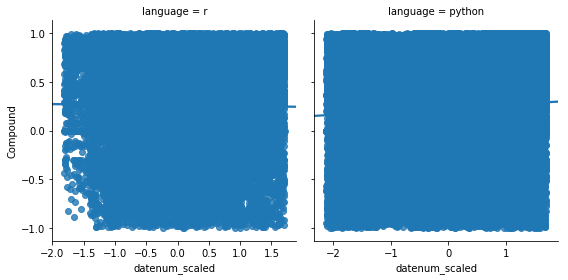

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import dates
import seaborn as sns
from sklearn import preprocessing

pl = sns.lmplot(x="datenum_scaled", y="Compound", data=data, col = "language", height=4, sharex=False)

Hmmm... that's quite noisy! Let's bin the answers within time periods and plot it again:

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


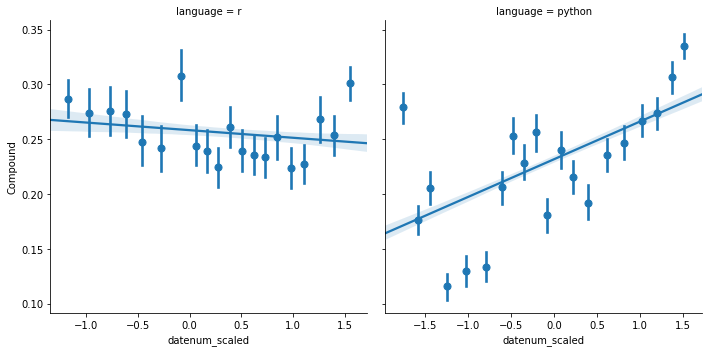

In [22]:
sns.lmplot(x="datenum_scaled", y="Compound", data=data, col = "language", fit_reg=True, x_estimator=np.mean, x_bins=20, sharex=False)

Okay we can now start to see the data a bit more clearly. Looking at that we might start to think that there are some patterns between the positivity (as determined by the Compound score) and time. For example, we might think that r users are getting less positive over time :( 

However, it's very hard to test this just by looking at these plots. For example, we know this data came from multiple users and as a result the data are likely not suitable for modelling with a simple linear relationship. We looked at this idea in a previous meetup on [**Mixed Effects Models**](https://www.kaggle.com/ojwatson/mixed-models). Make sure to have a read through that meetup for a refresher first.

---

Now you are all familiar with the assumptions necessary for using a linear model. One of these is that the residuals are homoscedastic, which means that the residuals are normally distributed in relation to the predicted value, i.e. are our predictions equally bad (or good) across our predicted values. We can look at this by plotting the residuals, using the package yellowbrick:

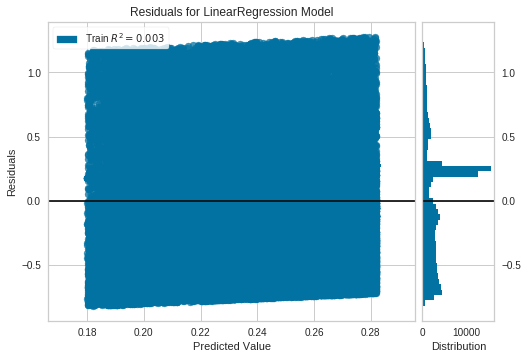

In [23]:
#!conda install -c districtdatalabs yellowbrick
import yellowbrick
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression

# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = data.datenum_scaled
y = data.Compound

# fit our model to the data
model.fit(x[:, np.newaxis], y)


# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model = model)

visualizer.fit(x[:, np.newaxis], y)  # Fit the training data to the model
visualizer.poof()                    # Draw/show/poof the data

Okay so that's the least useful plot! There is so much data that it's very difficult to view but it does look like the residuals are mostly equal across the output range. 

Next we should check for differences in the data due to structuring and repeat observations, i.e. due to multiple points coming from the same individuals.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


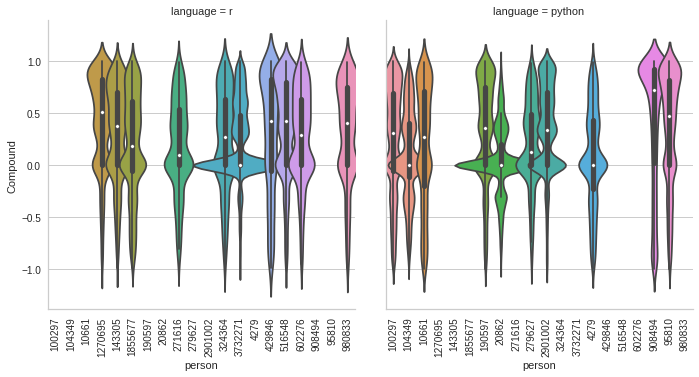

In [24]:
violins = sns.catplot(x="person", y="Compound", data=data, col='language', kind = "violin", width=6)
violins.set_xticklabels(rotation=90)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


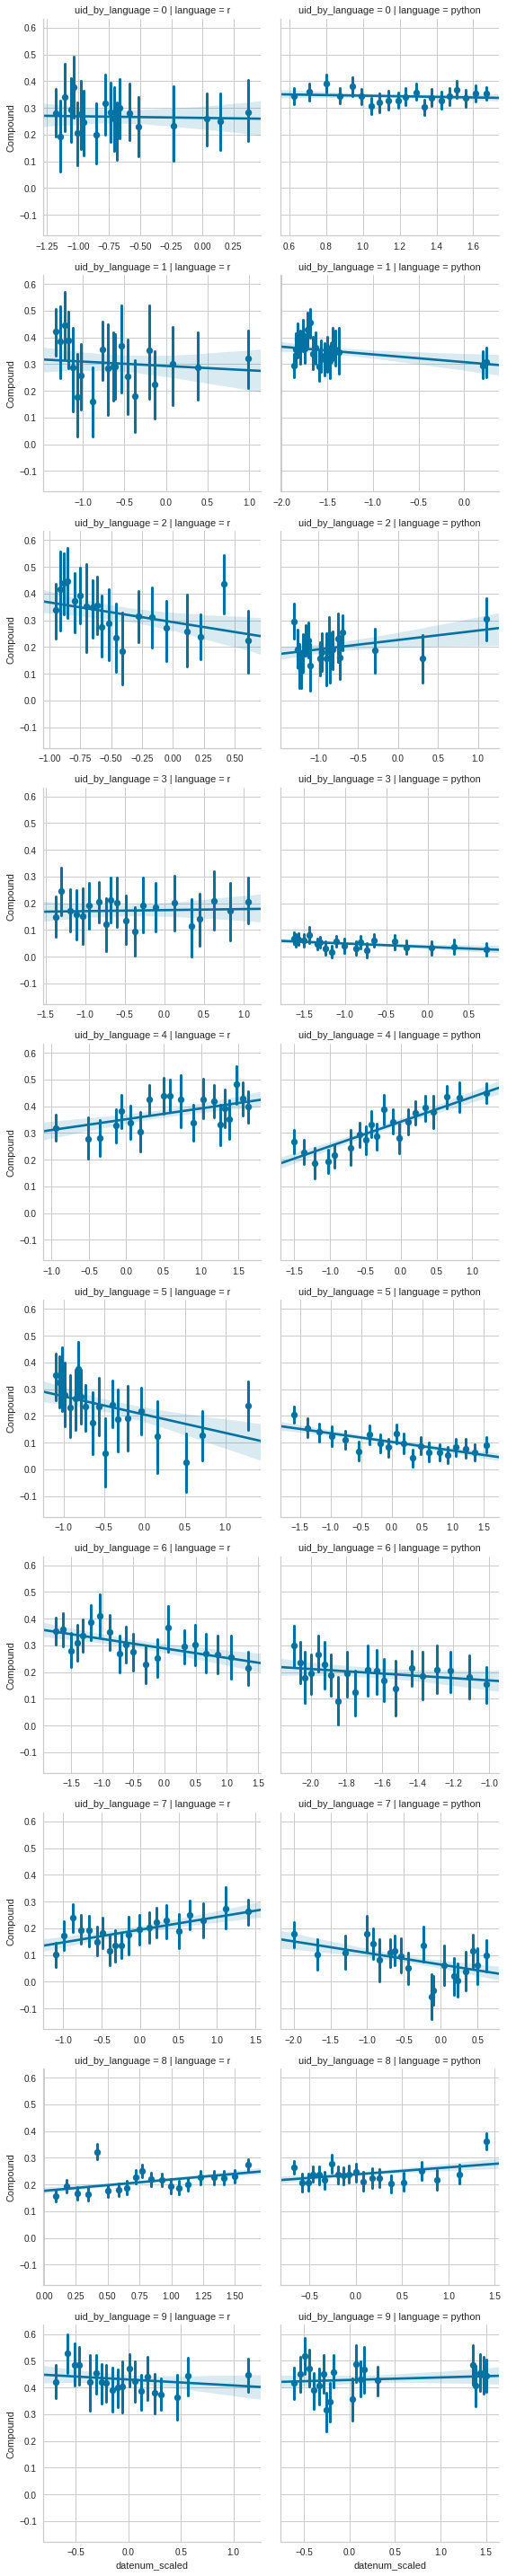

In [25]:
sns.lmplot(x="datenum_scaled", y="Compound", data=data, 
           row = "uid_by_language", col = "language", height=4, 
           fit_reg=True, x_estimator=np.mean, x_bins=20, sharex=False)

Okay - maybe there are some people who are becoming more/less positive over time :( 

BUT - are people in general becoming more or less positive over time. To do this we want to try and use all the data while acknowledging that the data in not independent. This is where the mixed effect model comes in, and we can use it to see the impact of time on the Compound score by treating the individual people as random effects, with each individual having a random slope and intercept with respect to time:

In [26]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# construct our mixed effect model, with a random slope and intercept for each person
md = smf.mixedlm("Compound ~ 0 + datenum_scaled + language", data, groups=data["person"], re_formula="~datenum_scaled")
mdf = md.fit()
print(mdf.summary())

                Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     Compound   
No. Observations:     127440      Method:                 REML       
No. Groups:           20          Scale:                  0.2100     
Min. group size:      1142        Likelihood:             -81461.4168
Max. group size:      19288       Converged:              Yes        
Mean group size:      6372.0                                         
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
language[python]            0.222    0.035  6.316 0.000  0.153  0.291
language[r]                 0.270    0.035  7.709 0.000  0.202  0.339
datenum_scaled             -0.003    0.009 -0.281 0.779 -0.021  0.016
Group Var                   0.013    0.009                           
Group x datenum_scaled Cov  0.001   

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


How about that - We can see that actually the trends are not significantly changing over time. This can be seen in the parameter table above for the `datenum_scaled` parameter, which although the estimated parameter is negative (`-0.004`), the 95% confidence interval includes 0 (`-0.022  0.013`), so we can not say that this is changing over time as the real value could in fact be 0. 

We can however say that the intercept for both languages is statistically positive. We could also change our setup to look at how each language is changing over time.

In [27]:
# construct our mixed effect model, with a random slope and intercept for each person
md = smf.mixedlm("Compound ~ 0 + datenum_scaled*language", data, groups=data["person"], re_formula="~datenum_scaled")
mdf = md.fit()
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     Compound   
No. Observations:       127440      Method:                 REML       
No. Groups:             20          Scale:                  0.2100     
Min. group size:        1142        Likelihood:             -81464.3970
Max. group size:        19288       Converged:              Yes        
Mean group size:        6372.0                                         
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
language[python]              0.224    0.036  6.284 0.000  0.154  0.294
language[r]                   0.268    0.036  7.528 0.000  0.198  0.338
datenum_scaled                0.000    0.013  0.031 0.976 -0.026  0.027
datenum_scaled:language[T.r] -0.007    0.019 -0.338 0.736 -0.045  0.032
Group Var

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2045: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Again no significant changes over time for either language!

# 7. Accepted Answers or Not

One last piece of analysis left to do! 

So far we have had a look at whether people were getting more angry or not over time. And they are not - hurray. But can we still suggest to people that it is in their best interest to be nicer, i.e. do the nicer answers become accepted more? Or is it just down to how subjective they are. For this we will have a go at building a few models to test how well we can predict if an answer is accepted or not based on their sentiment (and other factors if you have time).



In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

languages = data.language.unique()
data = pd.concat([data,pd.get_dummies(data.language)],axis=1)

training_colummns = ["Subjectivity", "Compound", "r", "python", "hour"]
X = data[training_colummns]
y = data['accepted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Just like last time we will start with a logistic regression model to train to our data for predicting whether an answer was accepted.

In [29]:
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)

Now that our model has been fit we can look at the predictions and see how well our model has performed. We had a [previous meetup](https://www.kaggle.com/blairyoung/diagnosing-with-evaluation-metics) that looked at how you can diagnose your machine learning model. If you need a refresher then have a head over to https://www.kaggle.com/blairyoung/diagnosing-with-evaluation-metics and have a go at that notebook.

In [30]:
print('f1 score {}'.format(f1_score(y_test, y_pred_log_reg, average='weighted')))
print('recall score {}'.format(recall_score(y_test, y_pred_log_reg, average='weighted')))
print('precision score {}'.format(precision_score(y_test, y_pred_log_reg, average='weighted')))

f1 score 0.3882302975716732
recall score 0.5426098535286284
precision score 0.5240206467936973


In [31]:
{key:value for key, value in zip(sorted(data['language'].unique()), f1_score(y_test, y_pred_log_reg, average=None))}

{'python': 0.01596071209330878, 'r': 0.7020630692026517}

Ew - seems like this was not a very good model. In particular it performed terribly for the python answers.

Next we'll try the random forest classifier. We had a look at what random forests are and more generally about what classification and regression trees are in one of [our meetups](https://github.com/central-ldn-data-sci/pushingTrees/blob/master/theory.ipynb). In that meetup we actually visualised what the tree actually is and then had a go at building one from scratch. But for now, let's stick with sklearn :)

> **Hint:** You need to fill in all the following code for the random forest fit

In [32]:
rf = None
# rf.fit(None, None)

In [33]:
y_pred_rf = None

In [34]:
print('f1 score {}'.format(None))
print('recall score {}'.format(None))
print('precision score {}'.format(None))


f1 score None
recall score None
precision score None


In [35]:
# {key:value for key, value in zip(sorted(data['language'].unique()), f1_score(y_test, y_pred_rf, average=None))}

Okay, so that is a bit better across both coding languages. But what was important in determining whether the answer was accepted? I.e. what was the model importance associated with each predictor. 

To do that we need to look back in our fitted model for the `feature_importances` and then we can plot these to see if the positivity had any impact. 

> **Hint:** You need to uncomment these lines of code and finish the for loop to create a dictionary with the feature names and their model importances.

In [36]:
feats = {} # a dict to hold feature_name: feature_importance

# Now loop over the columns in our input data (i.e. X) and the feature_importances_ in our random forest model
# for feature, importance in zip(None, None):
#    feats[feature] = importance #add the name/value pair 

# importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
# importances.sort_values(by='Gini-importance').plot(kind='bar', rot=45)

So the positivity is an important feature! :) And just about as important as the subjectivity of the answer. Interestingly, the hour of the answer being given was important. Maybe there is more information there (are people nicer in the morning?).

---

# 8. Wrap Up

Well done for getting this far! This was a really long meetup with a lot of material brought in (especially at the end). But if you have managed to work your way to here you will have picked up a huge array of skills, in particular how you can go from a research question to an actual dataset and some preliminary analysis. Reward yourselves with pizza!!!

![](https://i.imgflip.com/321u7a.jpg)

This was my last meetup topic for a while as I need to write up my PhD. :( Hopefully, this last topic covered lots of areas and refreshed some of our greatest hits. Don't worry if you did not have time to go through everything...

... or if you did and fancy there is some more material for those interested.

# 9. Take Home Challenges

We explored a lot of things here, but we really only touched the surface of a lot of topics. So have a go at answering these open ended questions/suggestions of what analysis could be done next. 

### 1. Stack Overflow User Reputation and Badges

Way back at the top of the meetup, we scraped the user IDs of the top users for the `r` and `python` tags from Stack Overflow. However, we could have grabbed more information! Go back and write a new scraping function to grab their reputation and the number of badges they have! Maybe these will be useful features in further analysis. 

### 2. Don't scrape - use BigQeury

OR... you could use knowledge of the user IDs to query BigQuery for this information. Or use the Stack Overflow API. Have a go at getting this data this way.

### 3. Top 10 revisited

So far we mostly used the sentiment analysis as features for looking at trends overall for the top 10 users. But, we could have changed the approach and modelled the user as a fixed effect to statistically test for whether each user has become more/less positive over time. Look back at some of the earlier material in the [Mixed Effects Meetup](https://www.kaggle.com/ojwatson/mixed-models) and build a linear model with the user treated as a fixed effect. Are there any user's who statistically get more or less positive over time?

### 4. More features plz.

Sentiment analysis was great at reviewing the answers given by the user's as a whole. However, we could have taken it one step further and assessed the text for specific words associated with accepted answers. Does it just take a few nice words to make your answer more likely to be accepted? Have a look back at Zack's [NLP Meetup Notebook](https://github.com/central-ldn-data-sci/web-scraping-and-nlp-CLDSPN/blob/master/%5BCOMPLETED%5D%20Web%20Scraping%20and%20NLP.ipynb) to see how we can get the sentiment for each word and then use that to predict which words are more often associated with accepted answers.

### 5. Scores on the doors

Lastly, our original extracte dataset from BigQuery also included a score column. This is the actual score of the answer as voted by user's for its usefulness etc. This surely must be linked to whether an answer is accepted. Have a go at bringing this into the random forest and see how this helps. Is there a threshold though for answers to usually be accepted?